# Imports and Constants

In [235]:
import sys
# sys.path is a list of absolute path strings
sys.path.append('..')

import itertools
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd 
import pickle
import seaborn as sns 
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics
import tensorflow as tf
from tensorflow import keras
import time
from tqdm import tqdm

import rhythm_regression.vector_processing as vp
import rhythm_regression.notebook_tools as nbt
from generate_model_data import *
from data_gen_constants import *
from preston_tools import grid_search_experiment, print_verbose


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Load Data

In [236]:
print('Loading examples')
train_examples, val_examples, test_examples = load_example_data()

print('Loading statistics')
train_stats = pd.read_csv(os.path.join(DATA_DIR, TRAIN_STATS_FILENAME), index_col=0)
val_stats = pd.read_csv(os.path.join(DATA_DIR, VAL_STATS_FILENAME), index_col=0)
test_stats = pd.read_csv(os.path.join(DATA_DIR, TEST_STATS_FILENAME), index_col=0)
print(f'Number of training blocks {len(train_stats)}')
print(f'Number of validation blocks {len(val_stats)}')
print(f'Number of testing blocks {len(test_stats)}')

print('Loading data generating parameters')
train_params = pd.read_csv(os.path.join(DATA_DIR, TRAIN_PARAMS_FILENAME), index_col=0)
val_params = pd.read_csv(os.path.join(DATA_DIR, VAL_PARAMS_FILENAME), index_col=0)
test_params = pd.read_csv(os.path.join(DATA_DIR, TEST_PARAMS_FILENAME), index_col=0)
print(f'Number of training params {len(train_params)}')
print(f'Number of validation params {len(val_params)}')
print(f'Number of testing params {len(test_params)}')


total_memory = sys.getsizeof(train_examples) + sys.getsizeof(val_examples) + sys.getsizeof(test_examples) + \
               sys.getsizeof(train_stats) + sys.getsizeof(val_stats) + sys.getsizeof(test_stats) + \
               sys.getsizeof(train_params) + sys.getsizeof(val_params) + sys.getsizeof(test_params)
print(f'Total memory: {total_memory}')


Loading examples
Number of training examples: 500
Number of validation examples: 300
Number of testing examples: 200
Loading statistics
Number of training blocks 25000
Number of validation blocks 15000
Number of testing blocks 10000
Loading data generating parameters
Number of training params 500
Number of validation params 300
Number of testing params 200
Total memory: 7656432


In [237]:
train_stats.head()

example_id  m_start  m_end  t_start  t_end  true_is_block_match  \
0           0       47    190       36    179                    0   
1           0      197    279      154    236                    0   
2           0       38    146        4    112                    0   
3           0      109    129      224    244                    0   
4           0        2     92      167    257                    0   

   block_length  sum_timestamp_residual  mean_timestamp_residual  \
0           143             2099.012649                14.678410   
1            82             2827.183531                34.477848   
2           108             1866.018100                17.277945   
3            20              636.300865                31.815043   
4            90             4642.690468                51.585450   

   max_timestamp_residual  sum_rhythm_residual  mean_rhythm_residual  \
0               24.620999            60.901064              0.428881   
1               38.287666            35.221894              0.434838   
2               27.563297            42.798496              0.399986   
3               32.846137             6.373386              0.335441   
4               54.399969            32.623521              0.366556   

   max_rhythm_residual  sum_accel_residual  mean_accel_residual  \
0             1.997185           89.106284             0.631959   
1             1.909058           52.024898             0.650311   
2             1.826307           60.715501             0.572788   
3             1.303517            9.252262             0.514015   
4             1.963316           52.336283             0.594730   

   max_accel_residual  index_distance  distance_length_product  
0            3.237339              11                     1573  
1            3.113655              43                     3526  
2            2.050096              34                     3672  
3            1.942145             115                     2300  
4            3.443509             165                    14850

In [238]:
train_params.head()

deletion_rate  insertion_rate  len_m  space_augmentation_rate  \
example_id                                                                  
0                    0.04             0.3    300                    0.003   
1                    0.30             0.5    200                    0.020   
2                    0.00             0.5    300                    0.010   
3                    0.00             0.1    300                    0.003   
4                    0.03             0.3    100                    0.050   

            space_reduction_rate  
example_id                        
0                          0.005  
1                          0.002  
2                          0.003  
3                          0.004  
4                          0.002

# EDA

In [5]:
train_stats.describe()

example_id       m_start         m_end       t_start         t_end  \
count  25000.000000  25000.000000  25000.000000  25000.000000  25000.000000   
mean     249.500000     61.002320    100.956080     60.762240    100.716000   
std      144.340165     58.881596     75.634631     63.404924     80.745122   
min        0.000000      0.000000      1.000000      0.000000      1.000000   
25%      124.750000     17.000000     40.000000     16.000000     38.000000   
50%      249.500000     39.000000     79.000000     38.000000     77.000000   
75%      374.250000     87.000000    154.000000     85.000000    146.000000   
max      499.000000    297.000000    300.000000    434.000000    446.000000   

       true_is_block_match  block_length  sum_timestamp_residual  \
count         25000.000000  25000.000000            25000.000000   
mean              0.003680     39.953760              763.214811   
std               0.060552     43.127048             1250.610423   
min               0.000000      1.000000                0.002058   
25%               0.000000     10.000000               57.095974   
50%               0.000000     24.000000              222.219436   
75%               0.000000     54.000000              879.160296   
max               1.000000    297.000000            10707.296790   

       mean_timestamp_residual  max_timestamp_residual  sum_rhythm_residual  \
count             25000.000000            25000.000000         25000.000000   
mean                 17.523154               20.162705            16.836215   
std                  18.924824               19.483224            18.691833   
min                   0.002058                0.002058             0.000000   
25%                   4.285665                6.365489             3.762033   
50%                  10.599988               13.326813            10.152107   
75%                  24.005938               27.613508            23.049315   
max                 128.696543              129.062372           128.679636   

       mean_rhythm_residual  max_rhythm_residual  sum_accel_residual  \
count          25000.000000         25000.000000        25000.000000   
mean               0.427769             1.613470           25.117943   
std                0.200313             0.805585           28.653698   
min                0.000000             0.000000            0.000000   
25%                0.338307             1.259549            5.021475   
50%                0.413808             1.727561           14.820062   
75%                0.501970             1.963127           34.690750   
max                5.387053             6.696211          201.561453   

       mean_accel_residual  max_accel_residual  index_distance  \
count         25000.000000        25000.000000    25000.000000   
mean              0.635766            1.994284       44.178000   
std               0.314362            1.044298       48.043181   
min               0.000000            0.000000        0.000000   
25%               0.496328            1.370727       11.000000   
50%               0.629460            2.026733       27.000000   
75%               0.767509            2.642420       61.000000   
max               5.078227            8.144300      408.000000   

       distance_length_product  
count             25000.000000  
mean               1993.051520  
std                3499.069826  
min                   0.000000  
25%                 138.000000  
50%                 546.000000  
75%                2236.000000  
max               42135.000000

In [6]:
#sns.histplot(train_stats[train_stats['true_is_block_match'] == 1], x='max_accel_residual', hue='true_is_block_match')
#sns.histplot(train_stats, x='max_accel_residual', hue='true_is_block_match')

<AxesSubplot: xlabel='block_length', ylabel='Count'>

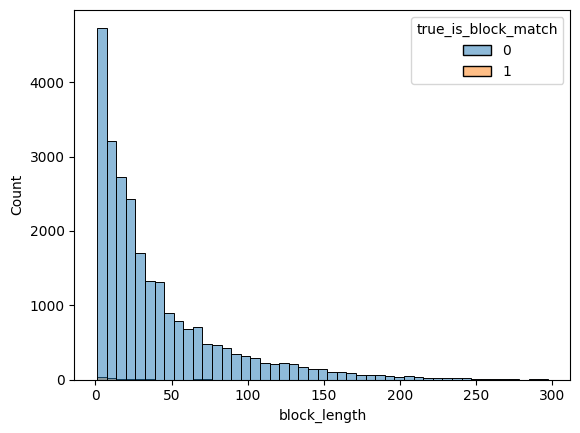

In [7]:
sns.histplot(train_stats, x='block_length', hue='true_is_block_match', bins=47)

In [8]:
eda_curve_constant = 1.1 * (train_stats[train_stats['true_is_block_match'] == 1]['distance_length_product'].max())
#CURVE_CONSTANT = 2000
print(eda_curve_constant)

# how many observations are there?
print(len(train_stats))

# how many observations are subject to index_distance * block_length < c
print((train_stats['distance_length_product'] < eda_curve_constant).sum())

# as a percentage now
print((train_stats['distance_length_product'] < eda_curve_constant).sum() / len(train_stats))

# maybe we can find a better curve than index_distance = c / block_length 
# to optimize over.  How can we reduce the number of candidate solutions to iterate over!


286.0
25000
9402
0.37608


C:\Users\prest\AppData\Local\Temp\ipykernel_17740\1140483398.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(np.arange(0,300), eda_curve_constant / np.arange(0,300), color='k')


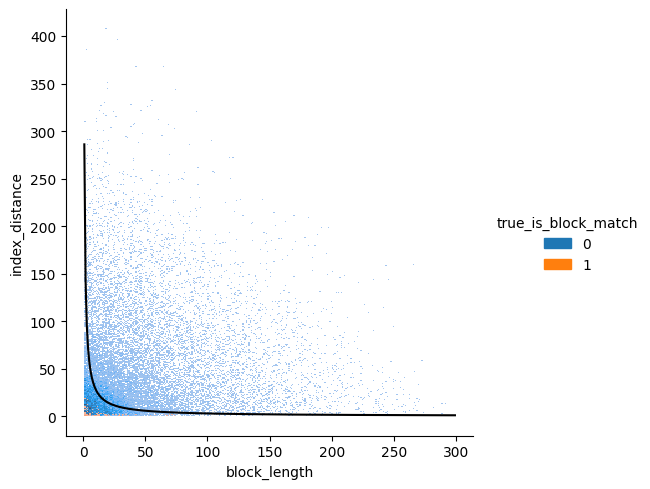

In [9]:
axs = sns.displot(train_stats, x="block_length", y="index_distance", hue='true_is_block_match', binwidth=(1,1))
plt.plot(np.arange(0,300), eda_curve_constant / np.arange(0,300), color='k')


# on this graph we want to minimize the number of all points below the curve while having all of the orange dots below the curve
# index_distance = c / block_length
# optimize parameter c to minimize count_dots(where index_distance * block_length < c) such that for all orange dots index_distance * block_length < c

253
246


C:\Users\prest\AppData\Local\Temp\ipykernel_17740\299784184.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(np.arange(0,300), eda_curve_constant / np.arange(0,300), color='k')


(0.0, 303.59999999999997)

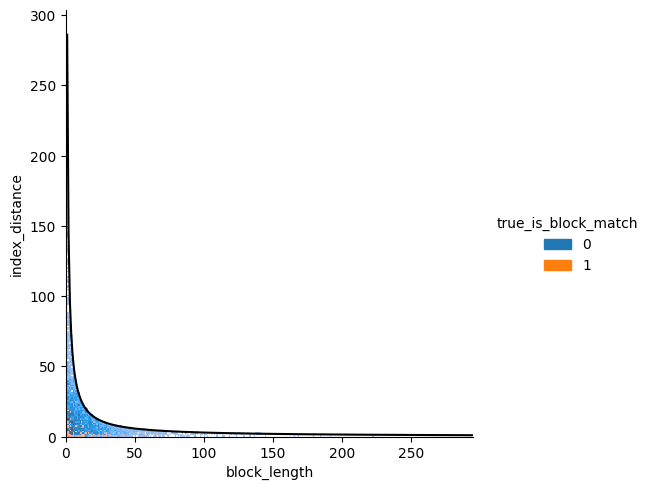

In [10]:
print(train_stats[train_stats['distance_length_product'] < eda_curve_constant]['index_distance'].max())
print(train_stats[train_stats['distance_length_product'] < eda_curve_constant]['block_length'].max())

axs = sns.displot(train_stats[train_stats['distance_length_product'] < eda_curve_constant], x="block_length", y="index_distance", hue='true_is_block_match', binwidth=(1,1))
plt.plot(np.arange(0,300), eda_curve_constant / np.arange(0,300), color='k')
plt.xlim((0, train_stats[train_stats['distance_length_product'] < eda_curve_constant]['block_length'].max() * 1.2))
plt.ylim((0, train_stats[train_stats['distance_length_product'] < eda_curve_constant]['index_distance'].max() * 1.2))


# on this graph we want to minimize the number of all points below the curve while having all of the orange dots below the curve
# index_distance = c / block_length
# optimize parameter c to minimize count_dots(where index_distance * block_length < c) such that for all orange dots index_distance * block_length < c

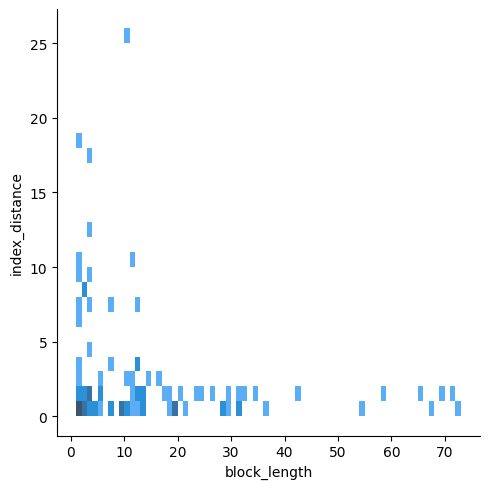

In [11]:
sns.displot(train_stats[train_stats['true_is_block_match'] == 1], x="block_length", y="index_distance", binwidth=(1,1))

<AxesSubplot: xlabel='distance_length_product', ylabel='Count'>

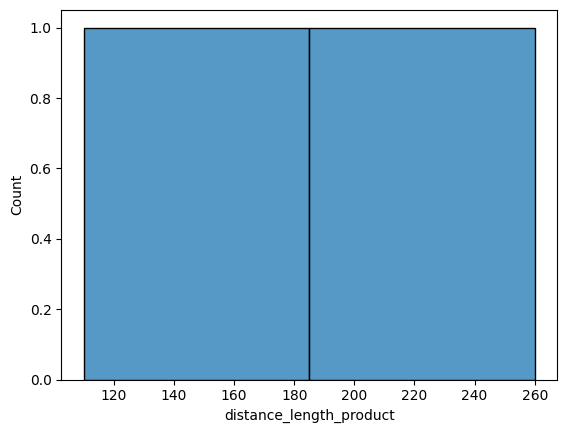

In [12]:
sns.histplot(train_stats[(train_stats['true_is_block_match'] == 1) & (train_stats['distance_length_product'] > 100)], x='distance_length_product')

In [13]:
train_stats[train_stats['true_is_block_match'] == 1].sort_values(by='distance_length_product', ascending=False).head(30)

example_id  m_start  m_end  t_start  t_end  true_is_block_match  \
1484           29      141    151      167    177                    1   
2919           58      148    159      138    149                    1   
5756          115       34     46       41     53                    1   
13511         270        7     78        6     77                    1   
10471         209       15     84       16     85                    1   
21504         430       19     84       18     83                    1   
7142          142       43    101       44    102                    1   
6809          136       84     87      101    104                    1   
17740         354       23     30       30     37                    1   
22453         449        5     47        4     46                    1   
3772           75       19     31       16     28                    1   
3497           69       77     80       89     92                    1   
24996         499       46     58       43     55                    1   
7133          142       91    125       92    126                    1   
12425         248       71     87       69     85                    1   
24234         484       58     90       57     89                    1   
20387         407        8     39        9     40                    1   
2524           50        8     37        7     36                    1   
19442         388       14     28       12     26                    1   
5959          119       16     19        7     10                    1   
2520           50       14     40       13     39                    1   
7634          152        3     27        2     26                    1   
17012         340       35     58       34     57                    1   
4321           86       76     87       74     85                    1   
24590         491       66     69       59     62                    1   
3776           75       35     42       32     39                    1   
2534           50       11     31       10     30                    1   
3031           60       38     48       40     50                    1   
19724         394        9     27        8     26                    1   
1254           25       41     42       23     24                    1   

       block_length  sum_timestamp_residual  mean_timestamp_residual  \
1484             10                9.538373                 0.953837   
2919             11               24.700606                 2.245510   
5756             12                2.976959                 0.248080   
13511            71               10.829384                 0.152527   
10471            69               23.729654                 0.343908   
21504            65                8.623000                 0.132662   
7142             58                9.728145                 0.167727   
6809              3                0.469110                 0.156370   
17740             7                4.573307                 0.653330   
22453            42               11.229318                 0.267365   
3772             12                6.193728                 0.516144   
3497              3                1.373136                 0.457712   
24996            12                4.908787                 0.409066   
7133             34                3.739167                 0.109976   
12425            16                4.132562                 0.258285   
24234            32               22.238363                 0.694949   
20387            31                4.287505                 0.138307   
2524             29                8.221147                 0.283488   
19442            14                0.865634                 0.061831   
5959              3                1.769708                 0.589903   
2520             26                6.135569                 0.235983   
7634             24                3.605839                 0.150243   
17012            23                5.320408             

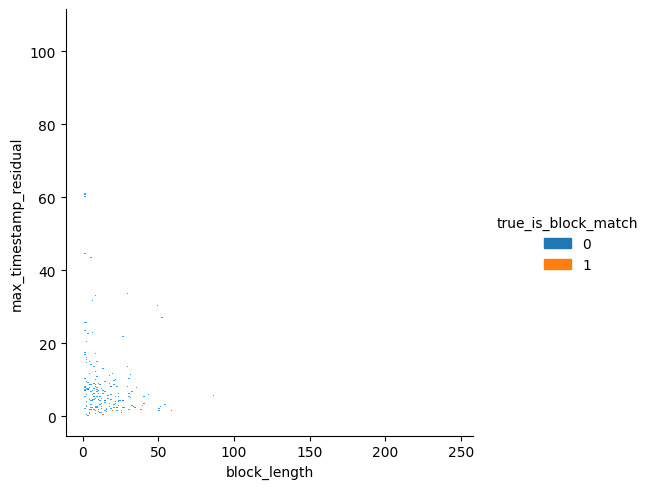

In [14]:
sns.displot(train_stats[train_stats['distance_length_product'] < eda_curve_constant], x="block_length", y="max_timestamp_residual", hue='true_is_block_match', binwidth=(1, 0.005))

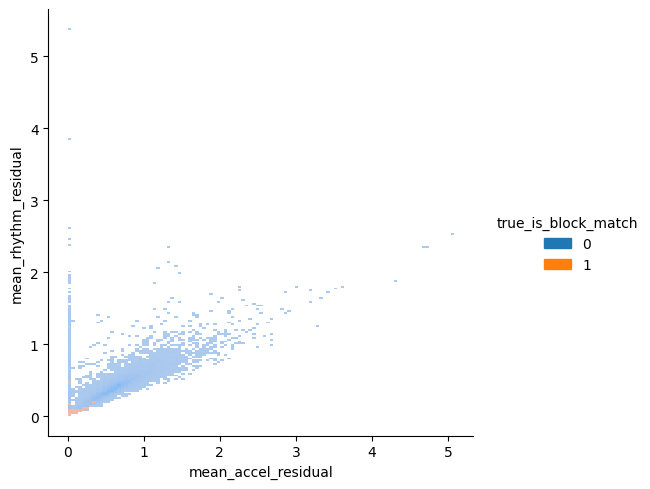

In [15]:
sns.displot(train_stats[train_stats['distance_length_product'] < eda_curve_constant], x="mean_accel_residual", y="mean_rhythm_residual", hue='true_is_block_match')

In [16]:
pd.concat({column: train_stats.groupby('true_is_block_match')[column].describe() for column in train_stats.columns})

count         mean  \
                        true_is_block_match                         
example_id              0                    24908.0   249.487755   
                        1                       92.0   252.815217   
m_start                 0                    24908.0    61.127911   
                        1                       92.0    27.000000   
m_end                   0                    24908.0   101.172635   
                        1                       92.0    42.326087   
t_start                 0                    24908.0    60.888309   
                        1                       92.0    26.630435   
t_end                   0                    24908.0   100.933034   
                        1                       92.0    41.956522   
true_is_block_match     0                    24908.0     0.000000   
                        1                       92.0     1.000000   
block_length            0                    24908.0    40.044725   
                        1                       92.0    15.326087   
sum_timestamp_residual  0                    24908.0   766.019879   
                        1                       92.0     3.773093   
mean_timestamp_residual 0                    24908.0    17.586699   
                        1                       92.0     0.318914   
max_timestamp_residual  0                    24908.0    20.235609   
                        1                       92.0     0.424624   
sum_rhythm_residual     0                    24908.0    16.894531   
                        1                       92.0     1.047832   
mean_rhythm_residual    0                    24908.0     0.429100   
                        1                       92.0     0.067548   
max_rhythm_residual     0                    24908.0     1.618756   
                        1                       92.0     0.182198   
sum_accel_residual      0                    24908.0    25.204670   
                        1                       92.0     1.637765   
mean_accel_residual     0                    24908.0     0.637764   
                        1                       92.0     0.094954   
max_accel_residual      0                    24908.0     2.000799   
                        1                       92.0     0.230500   
index_distance          0                    24908.0    44.332423   
                        1                       92.0     2.369565   
distance_length_product 0                    24908.0  2000.349326   
                        1                       92.0    17.250000   

                                                     std       min  \
                        true_is_block_match                          
example_id              0                     144.277816  0.000000   
                        1                     161.174394  6.000000   
m_start                 0                      58.927187  0.000000   
                        1                      29.358339  0.000000   
m_end                   0                      75.664020  1.000000   
                        1                      32.838636  1.000000   
t_start                 0                      63.460363  0.000000   
                        1                      30.939046  0.000000   
t_end                   0                      80.788198  1.000000   
                        1                      34.400649  1.000000   
true_is_block_match     0                       0.000000  0.000000   
                        1                       0.000000  1.000000   
block_length            0                      43.167526  1.000000   
                        1                      17.575025  1.000000   
sum_timestamp_residual  0                    1252.064373  0.012146   
                        1                       5.316135  0.002058   
mean_timestamp_residual 0                      18.930771  0.012146   
                        1                       0.342319  0.002058   
max_timestamp_residual  

<AxesSubplot: >

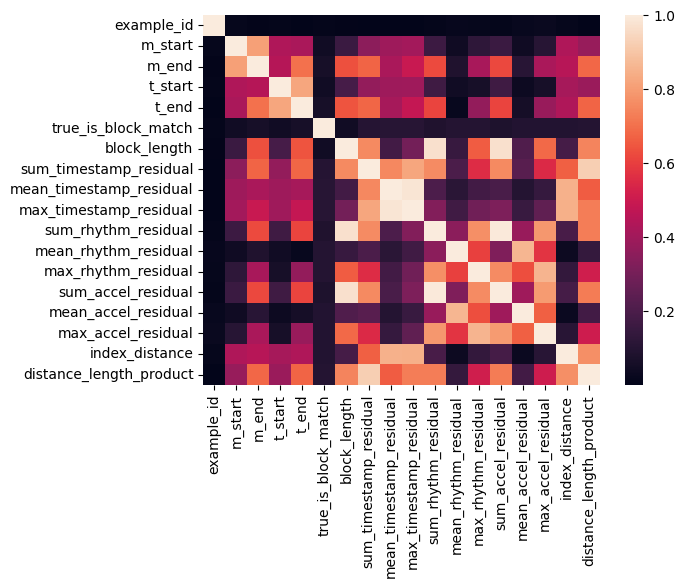

In [17]:
sns.heatmap(train_stats.sample(10000).corr(method='spearman').abs())

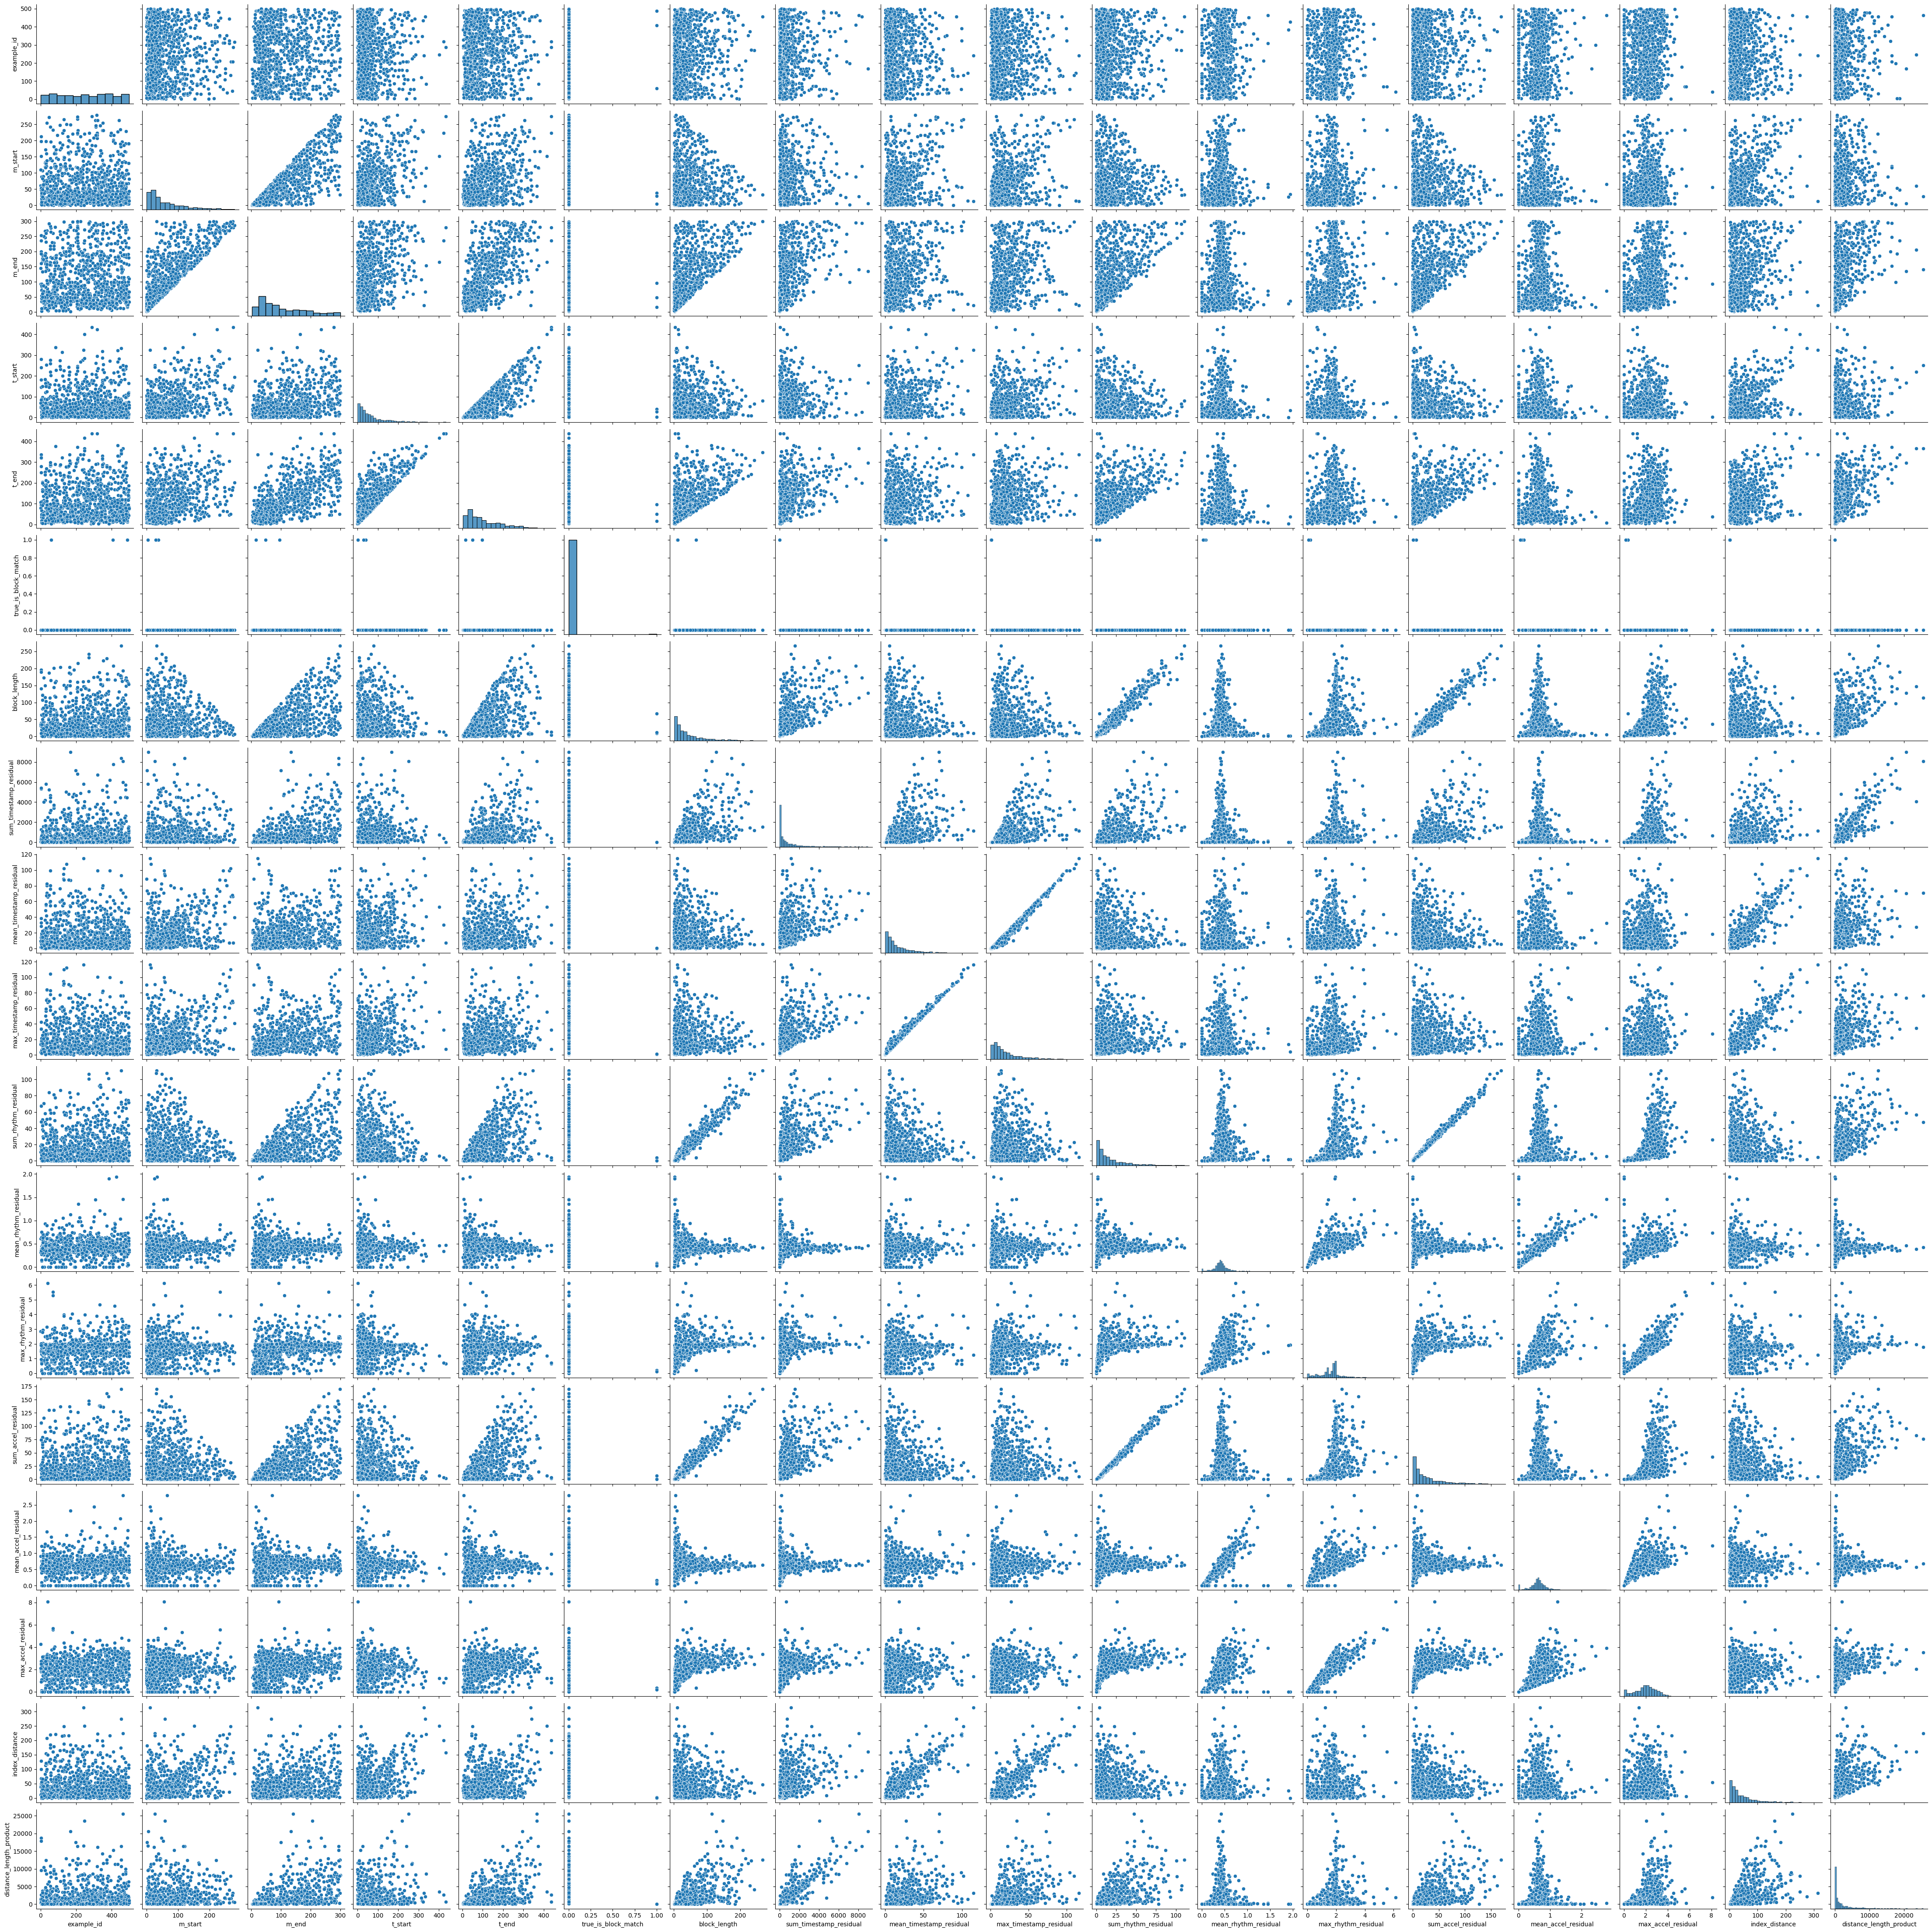

In [18]:
plot_sample = train_stats.sample(1000)
sns.pairplot(plot_sample)

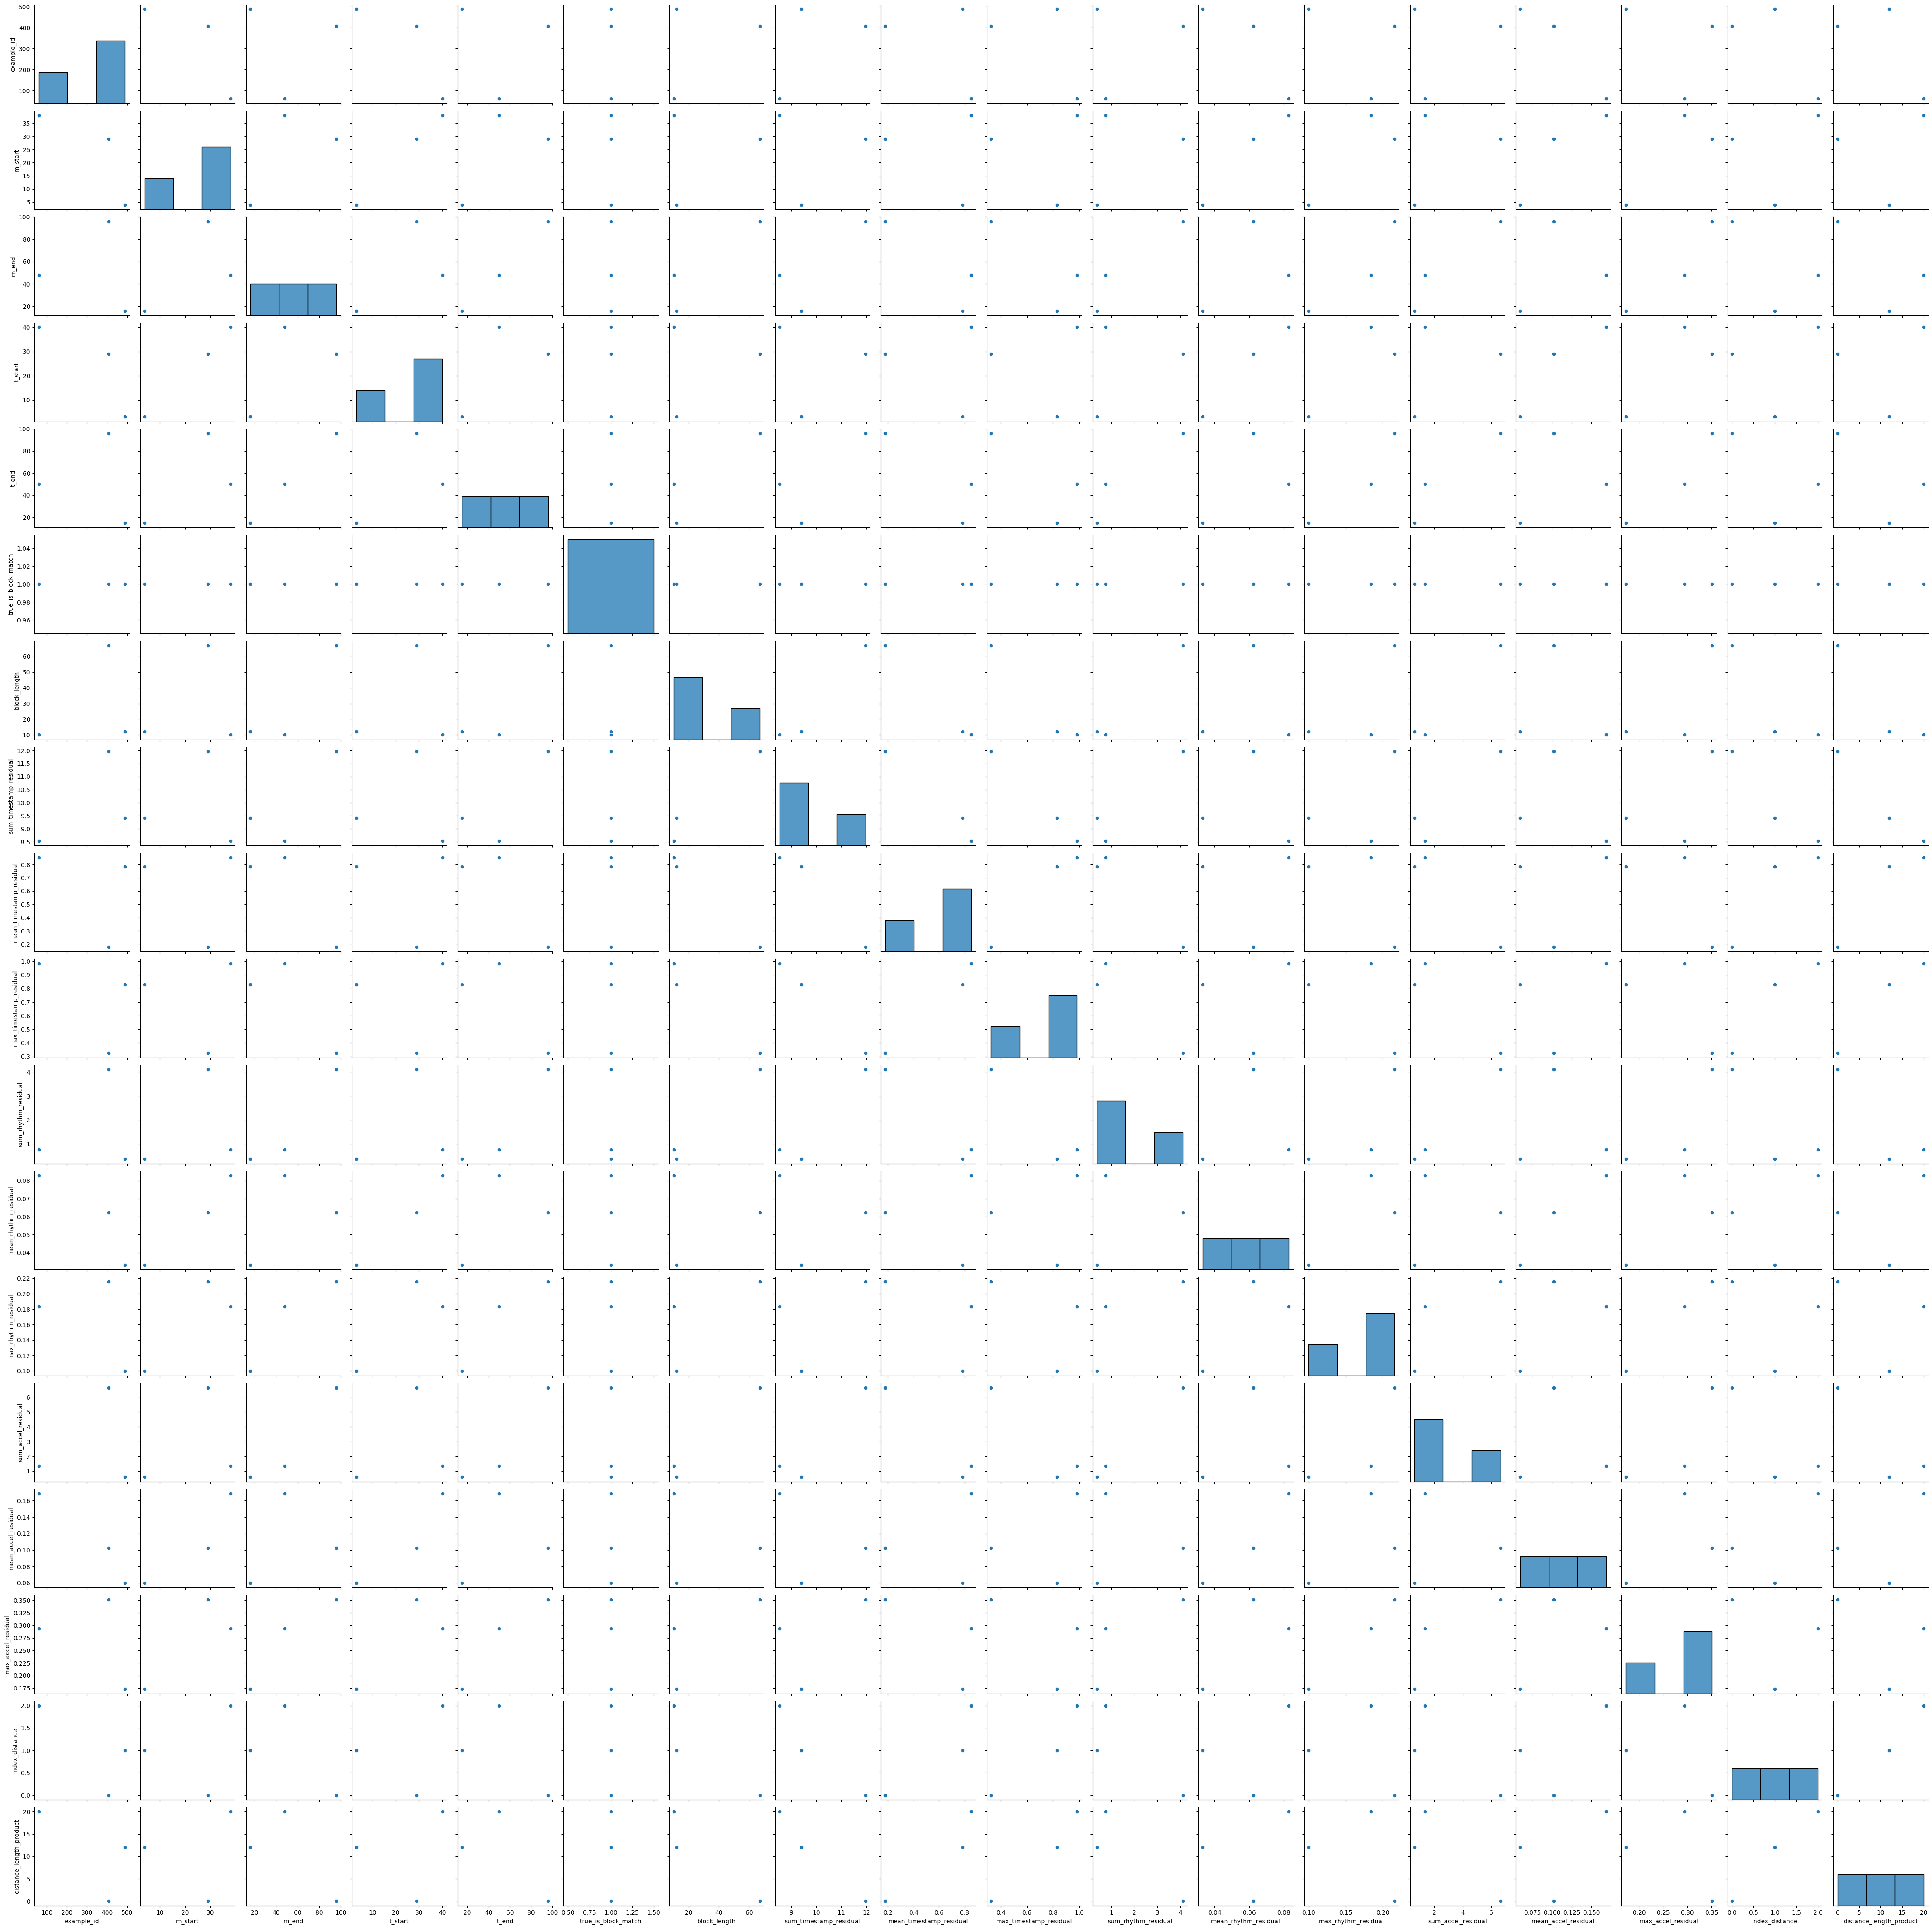

In [19]:
sns.pairplot(plot_sample[plot_sample['true_is_block_match'] == 1])

In [20]:
num_positives = (train_stats['true_is_block_match'] > 0.5).sum()
num_negatives = (train_stats['true_is_block_match'] <= 0.5).sum()
print(f'Proportion of examples that are positive: {num_positives / (num_positives + num_negatives)}')

Proportion of examples that are positive: 0.00368


In [21]:
train_stats.isnull().sum()

example_id                 0
m_start                    0
m_end                      0
t_start                    0
t_end                      0
true_is_block_match        0
block_length               0
sum_timestamp_residual     0
mean_timestamp_residual    0
max_timestamp_residual     0
sum_rhythm_residual        0
mean_rhythm_residual       0
max_rhythm_residual        0
sum_accel_residual         0
mean_accel_residual        0
max_accel_residual         0
index_distance             0
distance_length_product    0
dtype: int64

# Modeling Block Matches (Train Model)

In [278]:
# general data transforms: transforms we know we want every model to have

CURVE_CONSTANT = train_stats[train_stats['true_is_block_match'] == 1]['distance_length_product'].max() * 1.3 

FEATURE_COLUMNS = ['sum_timestamp_residual', 'mean_timestamp_residual', 'max_timestamp_residual',
                   'sum_rhythm_residual', 'mean_rhythm_residual', 'max_rhythm_residual',
                   'sum_accel_residual', 'mean_accel_residual', 'max_accel_residual',
                   'block_length', 'index_distance', 'distance_length_product'
                    ]


train_features = train_stats[train_stats['distance_length_product'] < CURVE_CONSTANT][FEATURE_COLUMNS]
train_labels = train_stats[train_stats['distance_length_product'] < CURVE_CONSTANT]['true_is_block_match']

val_features = val_stats[val_stats['distance_length_product'] < CURVE_CONSTANT][FEATURE_COLUMNS]
val_labels = val_stats[val_stats['distance_length_product'] < CURVE_CONSTANT]['true_is_block_match']

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features.values)
val_features = scaler.fit_transform(val_features.values)


print(train_features.shape)
print(train_labels.shape)
print(val_features.shape)
print(val_labels.shape)

(10281, 12)
(10281,)
(5910, 12)
(5910,)


In [240]:
def run_model(X_train, y_train, X_val, y_val, val_examples, verbose=0, **params):
    
    print_verbose('Training data', 1, verbose)
    model, history = train_model(X_train, y_train, X_val, y_val, params, verbose)

    print_verbose('Evaluating data', 1, verbose)
    metrics = evaluate_model(model, history, X_train, y_train, X_val, y_val, val_examples, params['batch_size'])

    return metrics, model 


def train_model(X_train, y_train, X_val, y_val, params, verbose):

    num_positives = y_train.sum()
    num_negatives = len(y_train) - num_positives
    output_bias_init = tf.keras.initializers.Constant(np.log([num_positives / num_negatives])) if params['use_initial_bias'] else None

    if len(params['architecture']) < 1:
        raise ValueError(f'Must have at least one layer in NN.  Got architecture: {params["architecture"]}')
    model = keras.Sequential(
        [keras.layers.Dense(params['architecture'][0], input_shape=(X_train.shape[1],), activation='relu')] \
        + [keras.layers.Dense(size, activation='relu') for size in params['architecture'][1:]] \
        + [keras.layers.Dense(1, bias_initializer=output_bias_init, activation='sigmoid')]
        )

    if verbose >= 2:
        model.summary()

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=(0.2 if params['use_label_smoothing'] else 0)), # label smooths to 0.1 and 0.9
        metrics=[
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]) 

    # Scaling by total/2 helps keep the loss to a similar magnitude.
    # The sum of the weights of all examples stays the same.
    weight_for_0 = (1 / num_negatives) * ((num_positives + num_negatives) / 2.0)
    weight_for_1 = (1 / num_positives) * ((num_positives + num_negatives) / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_prc', 
        verbose=verbose,
        patience=10,
        mode='max',
        restore_best_weights=True)

    history = model.fit(X_train,
                        y_train,
                        callbacks=[early_stopping],
                        epochs=params['max_epochs'],
                        batch_size=params['batch_size'],
                        class_weight=(class_weight if params['use_weighted_loss'] else None),
                        validation_split=0.2,
                        shuffle=True,
                        verbose=(verbose>=2))

    return model, history


def evaluate_model(model, history, X_train, y_train, X_val, y_val, val_examples, batch_size):

    train_metrics = {f'train_{key}': value for key, value in model.evaluate(X_train, y_train, batch_size=batch_size, return_dict=True, verbose=0).items()}
    val_metrics = {f'val_{key}': value for key, value in model.evaluate(X_val, y_val, batch_size=batch_size, return_dict=True, verbose=0).items()}
    return_metrics = {'epochs_trained': len(history.history['loss'])} | train_metrics | val_metrics

    return return_metrics

In [241]:
from sklearn.model_selection import ParameterGrid
import warnings

class GridSearchExperiment:

    def __init__(self, train_func, param_options, model_ranking_metric=None, maximize_metric=True):
        self.train_func = train_func
        self.param_options = param_options
        self.model_ranking_metric = model_ranking_metric 
        self.maximize_metric = maximize_metric

        self.results_df = None
        self.models = [] 

        self.best_model = None
        self.best_model_metric = None
        self.best_params = None

    def run(self, train_args=None, keep_models=False, exceptions='warn'):
        """
        Arguments
        train_args (dict): A dictionary of arguments to pass to train_func
        keep_models (bool): Whether or not to store all the models
        exceptions (['raise', 'warn', 'silence']): What to do with exceptions
        """
        
        if exceptions not in ['raise', 'warn', 'silence']:
            raise ValueError(f'excpetions parameter must be one of [raise, warn, silence]. Got value \'{exceptions}\'')

        grid = ParameterGrid(self.param_options)
        metrics_dicts = []
        metrics_keys = None

        best_model_metric = float('-inf') if self.maximize_metric else float('inf')

        for params in tqdm(grid):
            try:
                if train_args is None:
                    metrics, model = self.train_func(**params)
                else:
                    metrics, model = self.train_func(**train_args, **params)

                if self.model_ranking_metric is not None:

                    if self.model_ranking_metric not in metrics.keys():
                        raise ValueError(f'model_ranking_metric \'{self.model_ranking_metric}\' is not in the returned metrics from train_func: {metrics.keys()}')

                    if self.maximize_metric:
                        if metrics[self.model_ranking_metric] > best_model_metric:
                            self.best_model = model
                            self.best_model_metric = metrics[self.model_ranking_metric]
                            self.best_params = params
                    else:
                        if metrics[self.model_ranking_metric] < best_model_metric:
                            self.best_model = model
                            self.best_model_metric = metrics[self.model_ranking_metric]
                            self.best_params = params

                if keep_models:
                    self.models.append(model)
                
                # for summary and plotting functions, lists aren't hashable, so we convert them in the df to strings
                for key, value in params.items():
                    if isinstance(params[key], list):
                        params[key] = str(value)

                metrics_dicts.append(params | metrics) # merge the dictionaries with |
                if metrics_keys is None:
                    metrics_keys = metrics.keys()

            except Exception as e:
                if exceptions == 'raise':
                    raise e
                else:
                    if exceptions == 'warn':
                        warnings.warn(f'Encountered exception with parameters {params}: {e}')
                    if metrics_keys is None:
                        metrics_dicts.append({}) 
                    else:
                        metrics_dicts.append({key: np.nan for key in metrics_keys})

        self.results_df = pd.DataFrame(metrics_dicts)
        self.results_df.index.name = 'model_id'


    def evaluate_parameters(self, metric):
        if self.results_df is None:
            raise RuntimeError('Experiment has not been run yet, no results to show.')
        return pd.concat({column: self.results_df.groupby(column)[metric].describe() for column in self.param_options.keys()})


    def plot_parameter(self, hyperparameter, metric, plot_means=True, meanprops={'color': 'k', 'ls': '-', 'lw': 2}, jitter=0.1):
        if self.results_df is None:
                raise RuntimeError('Experiment has not been run yet, no results to show.')


        group_means = self.results_df.groupby(hyperparameter).mean(numeric_only=True)
        order = group_means.index

        plt.title('Hyperparameter Experimentation')
        sns.stripplot(self.results_df, x=hyperparameter, y=metric, order=order, jitter=jitter, orient='v')

        if plot_means:
            sns.boxplot(
                    data=self.results_df,
                    x=hyperparameter,
                    y=metric,
                    order=order,
                    showmeans=True,
                    meanline=True,
                    meanprops=meanprops,
                    medianprops={'visible': False},
                    whiskerprops={'visible': False},
                    zorder=10,
                    showfliers=False,
                    showbox=False,
                    showcaps=False)

        plt.xlabel(hyperparameter)
        plt.ylabel(metric)

In [280]:
"""
param_options = {
                'max_epochs': [100, 200],
                'batch_size': [128, 256, 512, 1024, 2048],
                'learning_rate': [1e-3],
                'architecture': [[16,32,64,32,16], [16,8,4], [64,64,32,16,4], [16,16,16,16,16]],
                'use_weighted_loss': [False, True],
                'use_initial_bias': [False, True],
                'use_label_smoothing': [False, True],
}
param_options = {
                'max_epochs': [5],
                'batch_size': [100000],
                'learning_rate': [1e-3, 1e-5, 1e-7],
                'architecture': [[16], [16,32]],
                'use_weighted_loss': [False],
                'use_initial_bias': [False],
                'use_label_smoothing': [False],
}
"""
param_options = {
                'max_epochs': [100],
                'batch_size': [256],
                'learning_rate': [1e-3],
                'architecture': [[16,32,64,32,16], [16,8,4], [64,64,32,16,4], [16,16,16,16,16]],
                'use_weighted_loss': [False],
                'use_initial_bias': [False],
                'use_label_smoothing': [False],
}


experiment = GridSearchExperiment(run_model, param_options, model_ranking_metric='val_prc')

experiment.run(train_args={'X_train': train_features, 
                           'y_train': train_labels, 
                           'X_val': val_features, 
                           'y_val': val_labels, 
                           'val_examples': val_examples, 
                           'verbose' : 0}, 
                exceptions='raise')

experiment.results_df.to_csv('./grid_results.csv')
experiment.best_model.save('./best_model.kerasmodel')

  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\prest\.virtualenvs\rhythm_regression-eMNZoTLC\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
100%|██████████| 4/4 [00:22<00:00,  5.74s/it]


INFO:tensorflow:Assets written to: ./best_model.kerasmodel\assets


In [281]:
results_df = pd.read_csv('./grid_results.csv')

best_model = keras.models.load_model('./best_model.kerasmodel')
best_model.summary()

results_df.sort_values(by='val_prc', ascending=False).head(10)

Model: "sequential_453"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2333 (Dense)          (None, 16)                208       
                                                                 
 dense_2334 (Dense)          (None, 16)                272       
                                                                 
 dense_2335 (Dense)          (None, 16)                272       
                                                                 
 dense_2336 (Dense)          (None, 16)                272       
                                                                 
 dense_2337 (Dense)          (None, 16)                272       
                                                                 
 dense_2338 (Dense)          (None, 1)                 17        
                                                                 
Total params: 1,313
Trainable params: 1,313
Non-trai

model_id          architecture  batch_size  learning_rate  max_epochs  \
3         3  [16, 16, 16, 16, 16]         256          0.001         100   
0         0  [16, 32, 64, 32, 16]         256          0.001         100   
1         1            [16, 8, 4]         256          0.001         100   
2         2   [64, 64, 32, 16, 4]         256          0.001         100   

   use_initial_bias  use_label_smoothing  use_weighted_loss  epochs_trained  \
3             False                False              False              35   
0             False                False              False              47   
1             False                False              False             100   
2             False                False              False              11   

   train_loss  train_tp  train_fp  train_tn  train_fn  train_accuracy  \
3    0.016603      53.0      18.0   10171.0      39.0        0.994456   
0    0.017507      62.0      32.0   10157.0      30.0        0.993969   
1    0.038767      37.0       5.0   10184.0      55.0        0.994164   
2    0.259082       0.0       0.0   10189.0      92.0        0.991051   

   train_precision  train_recall  train_prc  val_loss  val_tp  val_fp  val_tn  \
3         0.746479      0.576087   0.734827  0.011222    26.0    14.0  5866.0   
0         0.659574      0.673913   0.747045  0.017489    27.0    50.0  5830.0   
1         0.880952      0.402174   0.742226  0.031870    10.0     1.0  5879.0   
2         0.000000      0.000000   0.008949  0.254169     0.0     0.0  5880.0   

   val_fn  val_accuracy  val_precision  val_recall   val_prc  
3     4.0      0.996954       0.650000    0.866667  0.806255  
0     3.0      0.991032       0.350649    0.900000  0.745253  
1    20.0      0.996447       0.909091    0.333333  0.739587  
2    30.0      0.994924       0.000000    0.000000  0.005070

In [282]:
experiment.evaluate_parameters('val_prc')

count      mean       std       min  \
max_epochs          100                     4.0  0.574041  0.380513  0.005070   
batch_size          256                     4.0  0.574041  0.380513  0.005070   
learning_rate       0.001                   4.0  0.574041  0.380513  0.005070   
architecture        [16, 16, 16, 16, 16]    1.0  0.806255       NaN  0.806255   
                    [16, 32, 64, 32, 16]    1.0  0.745253       NaN  0.745253   
                    [16, 8, 4]              1.0  0.739587       NaN  0.739587   
                    [64, 64, 32, 16, 4]     1.0  0.005070       NaN  0.005070   
use_weighted_loss   False                   4.0  0.574041  0.380513  0.005070   
use_initial_bias    False                   4.0  0.574041  0.380513  0.005070   
use_label_smoothing False                   4.0  0.574041  0.380513  0.005070   

                                               25%       50%       75%  \
max_epochs          100                   0.555958  0.742420  0.760503   
batch_size          256                   0.555958  0.742420  0.760503   
learning_rate       0.001                 0.555958  0.742420  0.760503   
architecture        [16, 16, 16, 16, 16]  0.806255  0.806255  0.806255   
                    [16, 32, 64, 32, 16]  0.745253  0.745253  0.745253   
                    [16, 8, 4]            0.739587  0.739587  0.739587   
                    [64, 64, 32, 16, 4]   0.005070  0.005070  0.005070   
use_weighted_loss   False                 0.555958  0.742420  0.760503   
use_initial_bias    False                 0.555958  0.742420  0.760503   
use_label_smoothing False                 0.555958  0.742420  0.760503   

                                               max  
max_epochs          100                   0.806255  
batch_size          256                   0.806255  
learning_rate       0.001                 0.806255  
architecture        [16, 16, 16, 16, 16]  0.806255  
                    [16, 32, 64, 32, 16]  0.745253  
                    [16, 8, 4]            0.739587  
                    [64, 64, 32, 16, 4]   0.005070  
use_weighted_loss   False                 0.806255  
use_initial_bias    False                 0.806255  
use_label_smoothing False                 0.806255

Text(0.5, 1.0, 'Performance')

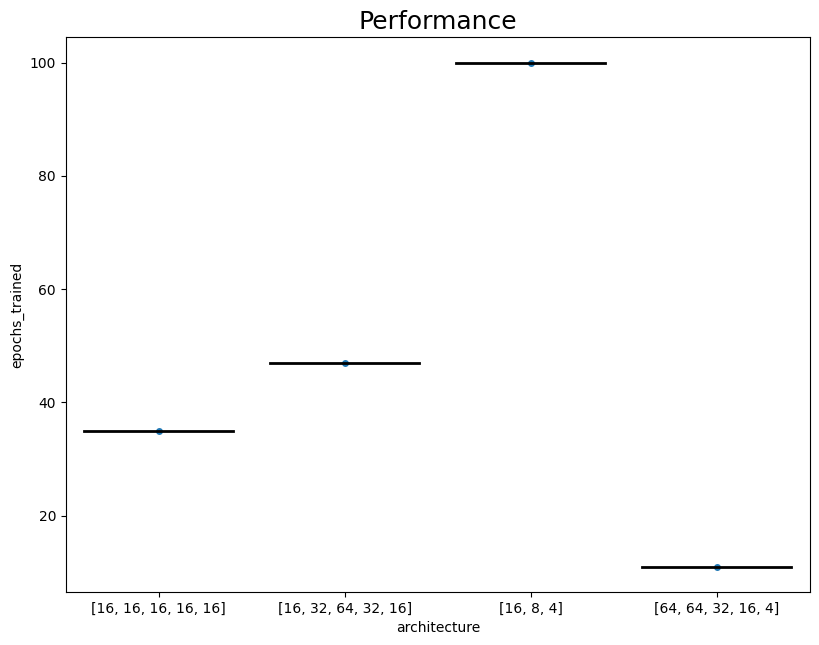

In [283]:
plt.figure(figsize=(1.5 * 6.4, 1.5 * 4.8))
experiment.plot_parameter('architecture', 'epochs_trained', jitter=0.1)
plt.title('Performance', fontsize=18)

C:\Users\prest\AppData\Local\Temp\ipykernel_17972\983965033.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(results_df.corr().abs())


<AxesSubplot: >

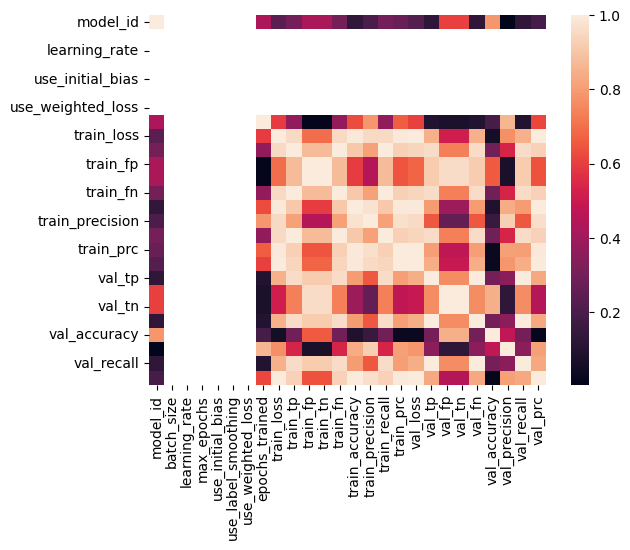

In [284]:
sns.heatmap(results_df.corr().abs())

# Evaluate Model

loss :  0.011222472414374352
tp :  26.0
fp :  14.0
tn :  5866.0
fn :  4.0
accuracy :  0.9969543218612671
precision :  0.6499999761581421
recall :  0.8666666746139526
prc :  0.806254506111145

6/6 [==============================] - 0s 1ms/step
Non-matches rejected (True Negatives):  5866
Non-matches accepted (False Positives):  14
Matches rejected (False Negatives):  4
Matches accepted (True Positives):  26
Total Matches:  30


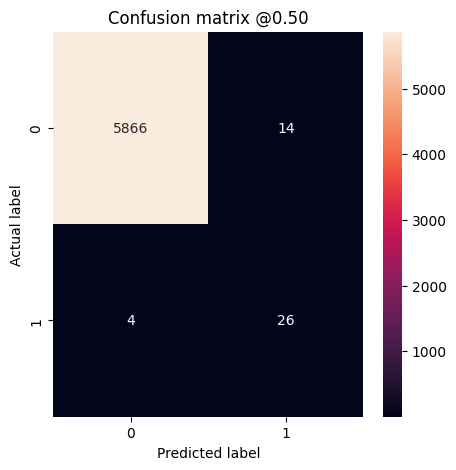

In [285]:
def plot_cm(labels, predictions, p=0.5):
  cm = sklearn.metrics.confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non-matches rejected (True Negatives): ', cm[0][0])
  print('Non-matches accepted (False Positives): ', cm[0][1])
  print('Matches rejected (False Negatives): ', cm[1][0])
  print('Matches accepted (True Positives): ', cm[1][1])
  print('Total Matches: ', np.sum(cm[1]))



baseline_results = best_model.evaluate(val_features, val_labels, batch_size=1024, verbose=0)
for name, value in zip(best_model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

y_pred = best_model.predict(val_features, batch_size=1024)
plot_cm(val_labels, y_pred)

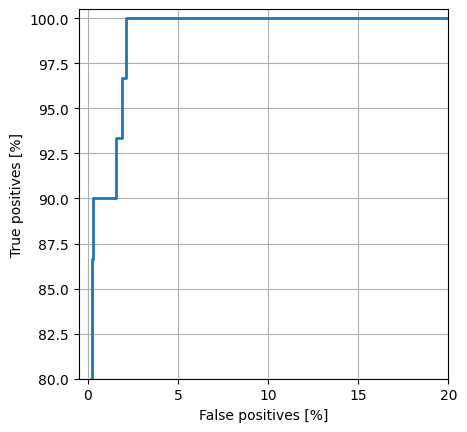

In [286]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')


plot_roc("Validation", val_labels, y_pred)


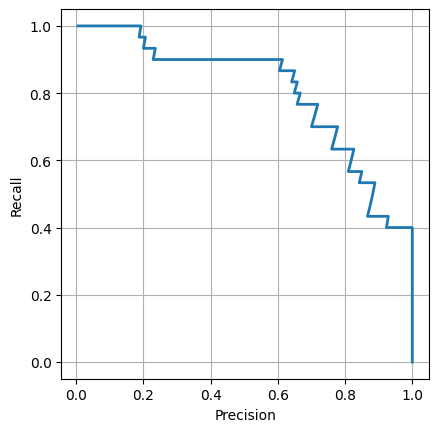

In [287]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Validation", val_labels, y_pred)

### I want to be able to see the precision and recall grouped by block length

In [288]:
plot_df = val_stats[val_stats['distance_length_product'] < CURVE_CONSTANT][['true_is_block_match', 'block_length']]
plot_df['prediction'] = y_pred.round()
plot_df['correct_prediction'] = (plot_df['true_is_block_match'] == plot_df['prediction']).astype('int64')
plot_df

true_is_block_match  block_length  prediction  correct_prediction
0                        0             9         0.0                   1
8                        0            35         0.0                   1
18                       0            10         0.0                   1
28                       0            62         0.0                   1
30                       0             3         0.0                   1
...                    ...           ...         ...                 ...
14995                    0            17         0.0                   1
14996                    0             3         0.0                   1
14997                    0            11         0.0                   1
14998                    0            26         0.0                   1
14999                    0             3         0.0                   1

[5910 rows x 4 columns]

In [289]:
plot_df.describe()

true_is_block_match  block_length   prediction  correct_prediction
count          5910.000000   5910.000000  5910.000000         5910.000000
mean              0.005076     15.662944     0.006768            0.996954
std               0.071072     20.016868     0.081997            0.055108
min               0.000000      1.000000     0.000000            0.000000
25%               0.000000      4.000000     0.000000            1.000000
50%               0.000000      9.000000     0.000000            1.000000
75%               0.000000     19.000000     0.000000            1.000000
max               1.000000    252.000000     1.000000            1.000000

In [290]:
num_correct_predcions = plot_df.groupby(by='block_length').sum()['correct_prediction']
total_predictions = plot_df.groupby(by='block_length').count()['correct_prediction']
(num_correct_predcions / total_predictions).mean()

0.9994870414550364

In [291]:
predictions = pd.DataFrame(y_pred)
predictions = predictions[predictions[0] > 0.05]
predictions.describe()

0
count  168.000000
mean     0.322290
std      0.244855
min      0.050137
25%      0.095679
50%      0.255765
75%      0.482609
max      0.857168

array([[<AxesSubplot: title={'center': '0'}>]], dtype=object)

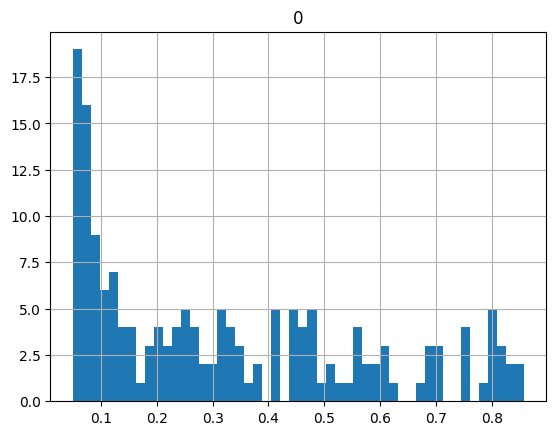

In [292]:
predictions.hist(bins=50)

In [293]:
predictions

0
20    0.235811
39    0.095170
43    0.146855
83    0.056365
84    0.051568
103   0.145706
109   0.304599
173   0.065650
176   0.808205
208   0.450080
216   0.104265
241   0.377851
244   0.745880
270   0.473846
332   0.703062
405   0.613741
460   0.072694
485   0.095849
511   0.321734
536   0.351965
575   0.416423
600   0.094145
648   0.302043
663   0.594287
755   0.276345
772   0.173853
774   0.442712
794   0.319163
830   0.095930
836   0.705952
846   0.559744
944   0.220496
953   0.335163
972   0.566188
974   0.133125
978   0.804141
995   0.079771
1003  0.057324
1083  0.059444
1085  0.063603
1100  0.103661
1112  0.066443
1130  0.312956
1154  0.054028
1171  0.811569
1370  0.270415
1477  0.329863
1555  0.586805
1589  0.824047
1594  0.242321
1673  0.079299
1753  0.604737
1767  0.155445
1879  0.055360
1974  0.555963
2060  0.080314
2115  0.154670
2199  0.062079
2208  0.412346
2251  0.803835
2269  0.254987
2367  0.081866
2499  0.682411
2513  0.061169
2531  0.821260
2566  0.334561
2581  0.798321
2623  0.274832
2625  0.454833
2634  0.798716
2655  0.479961
2681  0.050137
2682  0.064380
2727  0.065865
2732  0.700633
2777  0.200733
2826  0.091302
2845  0.077515
2891  0.057474
2922  0.256543
2929  0.079503
2940  0.134598
2967  0.250789
2968  0.343541
2970  0.750773
2978  0.289809
2983  0.461112
3000  0.062516
3004  0.440406
3017  0.839569
3153  0.455809
3203  0.057579
3217  0.314328
3326  0.082854
3329  0.857168
3332  0.115090
3349  0.119027
3373  0.315949
3487  0.833837
3500  0.081658
3521  0.744337
3669  0.851002
3671  0.441653
3674  0.184598
3676  0.386675
3697  0.068974
3844  0.113289
3921  0.490950
3988  0.628542
3992  0.668025
3997  0.081804
4034  0.685783
4083  0.066252
4354  0.155447
4355  0.055467
4383  0.128093
4393  0.201832
4401  0.125043
4484  0.072962
4564  0.207612
4584  0.359436
4610  0.206439
4643  0.066264
4771  0.179845
4796  0.482782
4804  0.262774
4806  0.464043
4816  0.226313
4903  0.120285
4965  0.238416
4972  0.259980
4982  0.108800
4983  0.103075
4984  0.122702
5069  0.406279
5162  0.342260
5166  0.087179
5167  0.066523
5188  0.752409
5301  0.185372
5304  0.505621
5398  0.408696
5482  0.243385
5484  0.437930
5524  0.254393
5528  0.482551
5567  0.683677
5576  0.518644
5579  0.102148
5583  0.073062
5588  0.780320
5604  0.093720
5611  0.075137
5612  0.567410
5621  0.537958
5622  0.330090
5627  0.476031
5632  0.092949
5697  0.569584
5729  0.146989
5751  0.073642
5784  0.513713
5806  0.564552
5839  0.227441
5841  0.608834
5876  0.252206
5879  0.129280
5901  0.414947

# Gap Block Match

In [326]:
parameter_table[ \
    (parameter_table['deletion_rate'] == 0) & \
    (parameter_table['insertion_rate'] == 0) & \
    (parameter_table['space_augmentation_rate'] == 0.05) & \
    (parameter_table['space_reduction_rate'] == 0) & \
    (parameter_table['len_m'] == 100)
]

NameError: name 'parameter_table' is not defined

In [249]:
train_stats.head()

example_id  m_start  m_end  t_start  t_end  true_is_block_match  \
0           0       47    190       36    179                    0   
1           0      197    279      154    236                    0   
2           0       38    146        4    112                    0   
3           0      109    129      224    244                    0   
4           0        2     92      167    257                    0   

   block_length  sum_timestamp_residual  mean_timestamp_residual  \
0           143             2099.012649                14.678410   
1            82             2827.183531                34.477848   
2           108             1866.018100                17.277945   
3            20              636.300865                31.815043   
4            90             4642.690468                51.585450   

   max_timestamp_residual  sum_rhythm_residual  mean_rhythm_residual  \
0               24.620999            60.901064              0.428881   
1               38.287666            35.221894              0.434838   
2               27.563297            42.798496              0.399986   
3               32.846137             6.373386              0.335441   
4               54.399969            32.623521              0.366556   

   max_rhythm_residual  sum_accel_residual  mean_accel_residual  \
0             1.997185           89.106284             0.631959   
1             1.909058           52.024898             0.650311   
2             1.826307           60.715501             0.572788   
3             1.303517            9.252262             0.514015   
4             1.963316           52.336283             0.594730   

   max_accel_residual  index_distance  distance_length_product  
0            3.237339              11                     1573  
1            3.113655              43                     3526  
2            2.050096              34                     3672  
3            1.942145             115                     2300  
4            3.443509             165                    14850

In [301]:
def model_is_block_match(model, feature_scaler, m_block, t_block, m_start, t_start, threshold=0.5):

    features = compute_block_features(m_block, t_block, m_start, t_start)
    features = np.array(list(features.values())).reshape(1, -1) # features are returned as a dictionary
    features= feature_scaler.transform(features)

    prediction = best_model.predict(features, verbose=0)[0,0]
    return  prediction >= threshold


def equality_is_block_match(m_block, t_block):
    if len(m_block) != len(t_block):
        raise ValueError('Blocks given are not the same size')
    
    return all([m_block[i] == t_block[i] for i, _ in enumerate(m_block)]) 

In [302]:
model_is_block_match(best_model, scaler, train_examples[0]['m'][38 : 146], train_examples[0]['t'][4 : 112], 38, 4)

False

In [310]:
def sub_gaps_of_length(gap, block_size):
    if block_size < MIN_BLOCK_SIZE:
        raise ValueError(f'Invalid block size {block_size}')
    return [(start, start + block_size) for start in range(gap[0], gap[1] - block_size + 1)]

def partition_gap(gaps, matched_sub_gap):

    if matched_sub_gap in gaps:
        gaps.remove(matched_sub_gap)
        return gaps

    for gap in gaps:
        if gap[0] <= matched_sub_gap[0] and matched_sub_gap[1] <= gap[1]:

            if gap[0] != matched_sub_gap[0]:
                gaps.append((gap[0], matched_sub_gap[0]))
            
            if gap[1] != matched_sub_gap[1]:
                gaps.append((matched_sub_gap[1], gap[1]))

            gaps.remove(gap)
            return gaps

def match_block(matchings, m_start, m_end, t_start, t_end):

    mi = m_start
    ti = t_start

    while mi < m_end and ti < t_end:
        matchings.append((mi, ti))
        mi += 1 
        ti += 1

def under_product_curve(candidate):
    m_gap, t_gap = candidate
    m_start, m_end = m_gap
    t_start, t_end = t_gap

    if m_end - m_start != t_end - t_start:
        raise ValueError(f'Unequal block sizes: {m_end - m_start} and {t_end - t_start}')

    block_size = m_end - m_start
    index_distance = abs((m_start - t_start))

    return (block_size * index_distance < CURVE_CONSTANT)

def gap_block_match(m, t, model, feature_scaler, threshold=0.5, true_matchings=None):

    vp.center_midi_on_transients(m, t)

    matchings = []

    blocks = []
    num_candidates_tested = 0
    num_candidates_tested_trace = []
    block_size_trace = []

    m_gaps = [(0, len(m))]
    t_gaps = [(0, len(t))]
    m_gap_sizes = [len(m)]
    m_gap_sizes = [len(t)]
    block_size = min(len(m), len(t))
    candidates_tested = set()


    while block_size > 0:

        num_candidates_tested_trace.append(num_candidates_tested)
        block_size_trace.append(block_size)

        # compute candidates
        candidate_m_gaps = [sub_gap for gap in m_gaps for sub_gap in sub_gaps_of_length(gap, block_size)]
        candidate_t_gaps = [sub_gap for gap in t_gaps for sub_gap in sub_gaps_of_length(gap, block_size)]
        candidate_m_gaps.sort()
        candidate_t_gaps.sort()

        #print(f'candidate_m_gaps: {candidate_m_gaps}')
        #print(f'candidate_t_gaps: {candidate_t_gaps}')
        #print(f'block_size: {block_size}')
        #print(f'm_gaps: {m_gaps}')
        #print(f't_gaps: {t_gaps}')

        candidates = [candidate for candidate in itertools.product(candidate_m_gaps, candidate_t_gaps) \
                      if (candidate not in candidates_tested) and under_product_curve(candidate)]

        match_found = False
        for candidate in candidates:
            m_gap, t_gap = candidate
            m_start, m_end = m_gap
            t_start, t_end = t_gap

            #print(f'Testing candidate ({m_start}, {m_end}, {t_start}, {t_end})')
            num_candidates_tested += 1
            candidates_tested.add(candidate)

            #if equality_is_block_match(m[m_start : m_end], t[t_start : t_end]):
            if true_is_block_match(true_matchings, m_start, m_end, t_start, t_end):
            #if model_is_block_match(model, feature_scaler, m[m_start : m_end], t[t_start : t_end], m_start, t_start, threshold):

                match_found = True

                #print(f'Found match ({m_start}, {m_end}, {t_start}, {t_end})')

                # add match
                blocks.append((m_start, m_end, t_start, t_end))
                match_block(matchings, m_start, m_end, t_start, t_end)
                
                # update_variables used to compute candidates

                m_gaps = partition_gap(m_gaps, (m_start, m_end))
                t_gaps = partition_gap(t_gaps, (t_start, t_end))

                if len(m_gaps) > 0 and len(t_gaps) > 0:
                    m_gap_sizes = [end - begin for begin, end in m_gaps]
                    t_gap_sizes = [end - begin for begin, end in t_gaps]
                    largest_testable_gap = min(max(m_gap_sizes), max(t_gap_sizes))
                    block_size = min(block_size, largest_testable_gap)
                    #print(f'New block size: {block_size}')
                    #print(f'num_candidates_tested: {num_candidates_tested}')

                break

        if not match_found:
            block_size -= 1
            #print(f'New block size: {block_size}')
            #print(f'num_candidates_tested: {num_candidates_tested}')

        if len(m_gaps) == 0 or len(t_gaps) == 0:
            break

    # deletions
    for gap_begin, gap_end in m_gaps:
       for i in range(gap_begin, gap_end):
            matchings.append((i, None))

    # insertions
    for gap_begin, gap_end in t_gaps:
       for i in range(gap_begin, gap_end):
            matchings.append((None, i))

    # sort matchings
    matchings.sort(key=lambda tup: tup[0] if tup[0] is not None else tup[1])
    vp.validate_matching(m, t, matchings)

    return matchings, blocks, m_gaps, t_gaps, num_candidates_tested, num_candidates_tested_trace, block_size_trace

# We now only test candidates that are elligible.  We must now narrow down these to LIKELY candidates
# under_product_curve() is really a type of is_good_candidate().  We can make a better function.  
# we want to use statistics / ML to create is_good_candidate() and is_block_match()

# Think of it like nested sets:
# All Block Pairs > elligible block matches > good candidates for a match > actual matches

In [312]:
jaccard_scores = [None] * len(val_examples)
times = [None] * len(val_examples)


for i in tqdm(range(len(val_examples))):
    start_time = time.time()


    output = gap_block_match(val_examples[i]['m'], val_examples[i]['t'], best_model, scaler, threshold=0.5, true_matchings=val_examples[i]['matchings'])
    if isinstance(output[0], int):
        print(output[0])
    jaccard_scores[i] = vp.score_matching(output[0], val_examples[i]['matchings'])


    end_time = time.time()
    
    times[i] = end_time - start_time


100%|██████████| 300/300 [11:38<00:00,  2.33s/it]


In [316]:
pd.Series(times).describe()

count    300.000000
mean       2.329297
std        3.380711
min        0.000000
25%        0.101997
50%        0.976197
75%        3.219561
max       16.472541
dtype: float64

In [325]:
time_df = val_params.copy()
time_df['algo_time'] = times
time_df.corr()

deletion_rate  insertion_rate     len_m  \
deletion_rate                 1.000000       -0.076946  0.031892   
insertion_rate               -0.076946        1.000000  0.100426   
len_m                         0.031892        0.100426  1.000000   
space_augmentation_rate       0.022600        0.019012  0.044411   
space_reduction_rate          0.089314       -0.102735  0.019446   
algo_time                    -0.053936        0.476096  0.758903   

                         space_augmentation_rate  space_reduction_rate  \
deletion_rate                           0.022600              0.089314   
insertion_rate                          0.019012             -0.102735   
len_m                                   0.044411              0.019446   
space_augmentation_rate                 1.000000             -0.038424   
space_reduction_rate                   -0.038424              1.000000   
algo_time                               0.026250             -0.072319   

                         algo_time  
deletion_rate            -0.053936  
insertion_rate            0.476096  
len_m                     0.758903  
space_augmentation_rate   0.026250  
space_reduction_rate     -0.072319  
algo_time                 1.000000

It looks like insertions and length are the most time expensive parts of the algorithm

<AxesSubplot: >

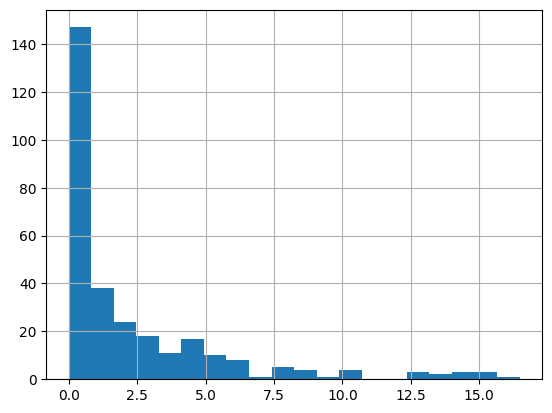

In [321]:
pd.Series(times).hist(bins=20)

In [317]:
pd.Series(jaccard_scores).describe()

count    300.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
dtype: float64

In [304]:
output = gap_block_match(val_examples[0]['m'], val_examples[0]['t'], best_model, scaler, threshold=0.5)

print(vp.score_matching(output[0], val_examples[0]['matchings']))

output

New block size: 193
num_candidates_tested: 2
New block size: 192
num_candidates_tested: 7
New block size: 191
num_candidates_tested: 15
New block size: 190
num_candidates_tested: 26
New block size: 189
num_candidates_tested: 40
New block size: 188
num_candidates_tested: 57
New block size: 187
num_candidates_tested: 77
New block size: 186
num_candidates_tested: 100
New block size: 185
num_candidates_tested: 126
New block size: 184
num_candidates_tested: 155
New block size: 183
num_candidates_tested: 187
New block size: 182
num_candidates_tested: 222
New block size: 181
num_candidates_tested: 260
New block size: 180
num_candidates_tested: 301
New block size: 179
num_candidates_tested: 345
New block size: 178
num_candidates_tested: 392
New block size: 177
num_candidates_tested: 442
New block size: 176
num_candidates_tested: 495
New block size: 175
num_candidates_tested: 551
New block size: 174
num_candidates_tested: 610
New block size: 173
num_candidates_tested: 672
New block size: 172
nu

KeyboardInterrupt: 

In [ ]:
plt.plot(output[-2])

In [ ]:
plt.plot(output[-1])

In [ ]:
num_blocks(len(sample_examples[0]['m']), len(sample_examples[0]['t']))

In [ ]:
test_m = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']
test_t = ['z', 'z', 'a', 'b', 'c', 'd', 'z', 'g', 'i', 'j', 'k', 'z', 'z', 'z', 'l']

#test_m = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']
#test_t = ['z', 'z', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'z', 'z']


# we should compute max_{timestamp,rhythm,accel}_residual also.  With enough note, a small section that invalidates the match can be averaged out into a match


gap_block_match(test_m, test_t)

# Tune Model to Optimize Matching Algorithm

In [ ]:
def optimize_prc_curve

# Other Ideas / Notes

**Good Strategies**
- Snapping
- `np.isclose()`
- Differencing to get rhythm vectors
- Normalizing those rhythm vectors by dividing by a reference rhythm. Good candidates include
    - Quarter note length in seconds computed from MIDI observed tempo
    - The first note of t and m
    - The first note of m
    - The first note of a pattern.  Patterns are local
- Abstract away tempo by normalizing the timestamps (or rhythms, idk)
    - Every input to my algorithm should be normalized to be the same tempo.  They way I can decide thresholds for things without having to worry about if the thresholds change as tempo does.  WAIT NO THIS DOESN'T WORK.  A 32nd note of difference might be acceptable at 168, but not at 60 bpm.

**Requirements**
- Pre Matching
    - Match together extended sections of rhythms which are the same.

**Strategies to test**
- Give a score for a match, not a boolean
    - We want to score longer matches higher?
    - Perhaps there's a threshold
- Tempo invariant matching (normalization)
    - Requires a minimum of two rhythms (3 notes)
- I bet we can write the log_t_diff distribution as a Guassian Mixture Model, where the means are the unique(log(m_diff))